# Implementation of Scheffe-Wald test on a Penalty analysis

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CURRENT_PATH = Path.cwd()
MAIN_DIR = os.path.abspath(CURRENT_PATH.parent)
INPUT_DIR = os.path.join(CURRENT_PATH, 'data')

In [3]:
sys.path.append(MAIN_DIR)

from MultipleTesting.multiple_comparisons import *
from MultipleTesting.visualization import *

# READ DATA

In [4]:
df = pd.read_csv(os.path.join(INPUT_DIR,'dt_compMult_formula_182.csv' ))

CONTEOS = (
    df
    .groupby(['atributo','nivel'])['sbj_num']
    .nunique()
    .reset_index()
)


In [18]:
OVERALL_LIKING = pd.read_csv(os.path.join(INPUT_DIR, 'dt_penalty.csv'))
OVERALL_LIKING['atributo'] = OVERALL_LIKING['atributo'].str.lower()
OVERALL_LIKING['nivel'] = OVERALL_LIKING['nivel'].str.upper()


In [6]:
def get_counts_for_attribute(df_counts: pd.DataFrame, measurement: str, atributo: str) -> list:
    """
    Extracts counts in order JAR, TL, TM for a given attribute.
    """
    counts = df_counts[df_counts['atributo'] == atributo].sort_values('nivel')
    return [
        counts[counts['nivel'] == 'JAR'][measurement].iloc[0],
        counts[counts['nivel'] == 'TL'][measurement].iloc[0],
        counts[counts['nivel'] == 'TM'][measurement].iloc[0]
    ]

(<Figure size 1500x800 with 4 Axes>,
 (<Axes: title={'center': 'Proporción de Respuestas'}, xlabel='nivel', ylabel='atributo'>,
  <Axes: title={'center': 'Diferencias Overall Liking\n(vs JAR)'}, ylabel='atributo'>))

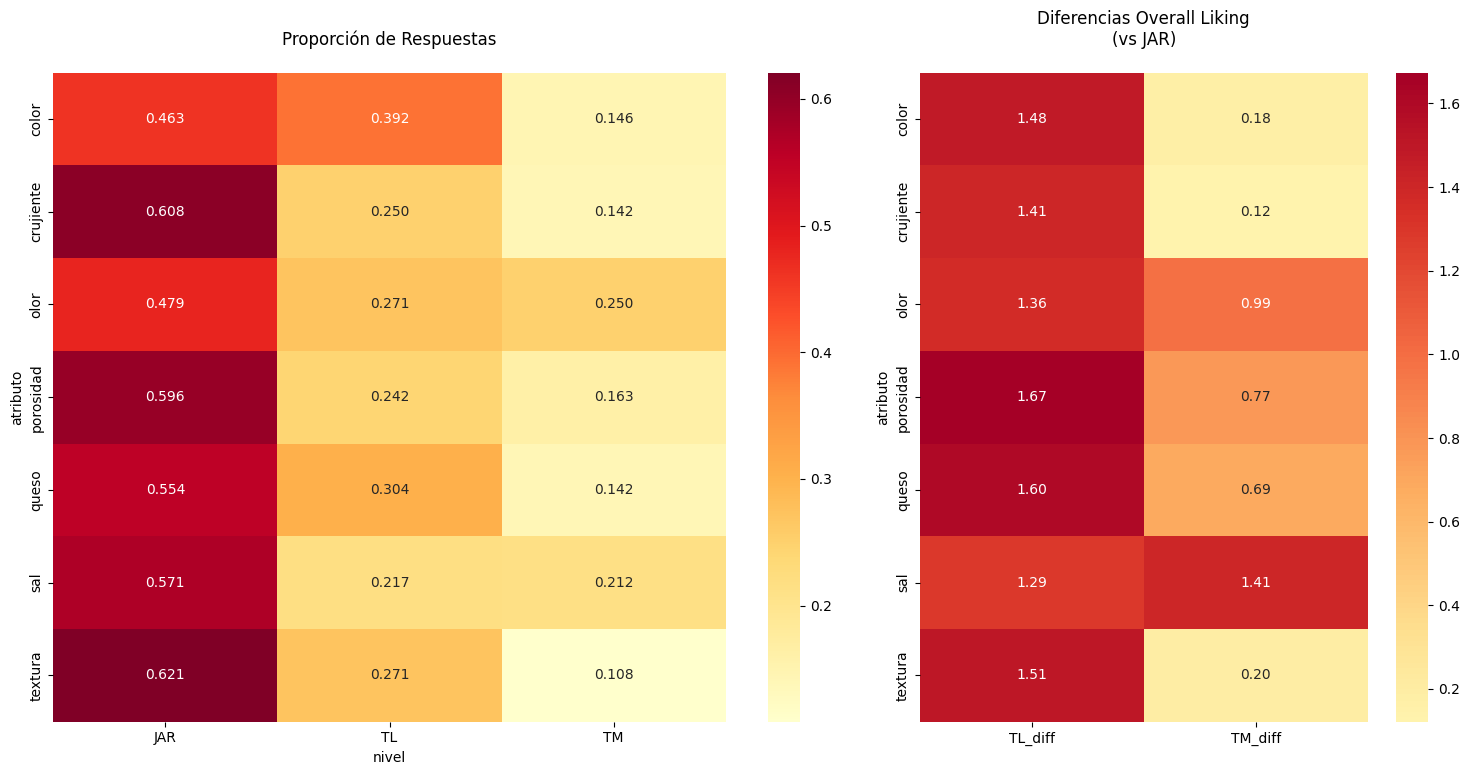

In [7]:
def plot_penalty_heatmap(df_ol: pd.DataFrame, df_counts: pd.DataFrame, title: str = "Penalty Analysis Heatmap"):
    """
    Creates a heatmap visualization using DataFrames.
    """
    # Prepare data for proportions
    prop_data = df_counts.pivot_table(
        values='sbj_num', 
        index='atributo', 
        columns='nivel', 
        aggfunc='sum'
    )
    
    # Calculate proportions
    total_responses = prop_data.sum(axis=1)
    prop_data = prop_data.div(total_responses, axis=0)
    
    # Calculate overall liking differences
    ol_data = df_ol.pivot_table(
        values='overall_liking',
        index='atributo',
        columns='nivel'
    )
    
    ol_diffs = pd.DataFrame({
        'TL_diff': ol_data['JAR'] - ol_data['TL'],
        'TM_diff': ol_data['JAR'] - ol_data['TM']
    })
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [1.5, 1]})
    
    # Plot proportions heatmap
    sns.heatmap(prop_data, 
                annot=True, 
                fmt='.3f',
                cmap='YlOrRd',
                ax=ax1)
    ax1.set_title('Proporción de Respuestas', pad=20)
    
    # Plot overall liking differences heatmap
    sns.heatmap(ol_diffs,
                annot=True,
                fmt='.2f',
                cmap='RdYlBu_r',
                center=0,
                ax=ax2)
    ax2.set_title('Diferencias Overall Liking\n(vs JAR)', pad=20)
    
    plt.suptitle(title, fontsize=14, y=1.05)
    plt.tight_layout()
    return fig, (ax1, ax2)

plot_penalty_heatmap(OVERALL_LIKING, CONTEOS, title="")

# Testing

In [8]:
df_result = pd.DataFrame()
alpha = 0.1

# Matriz de contraste para las comparaciones
A = np.array([
    [1, -1, 0],   # JAR vs TL
    [1, 0, -1],   # JAR vs TM
])

for attribute in CONTEOS['atributo'].unique():
    counts = get_counts_for_attribute(CONTEOS, 'sbj_num', attribute) # porportions are computed inside

    test = StatisticalTest(counts, alpha=alpha)

    bonf_results = test.bonferroni_confidence_intervals()
    tukey_results = test.tukey_confidence_intervals()
    scheffe_results = test.scheffe_wald_test(A)

    all_results = [scheffe_results, bonf_results, tukey_results]

    # Print results 
    print(str.upper(attribute),"*" * 70)
    print_test_results(all_results)
    print("=" * 80)

    for method in all_results:
        result = format_test_results_df(method)
        result['attribute'] = attribute
        
        df_result = pd.concat([df_result, result]) 

df_result['p_i-p_j'] = df_result['p_i-p_j'].str.replace('0','JAR').str.replace('1','TL').str.replace('2','TM').str.replace('p_','')


COLOR **********************************************************************

--------------------------------------------------------------------------------
Scheffé-Wald Results:
--------------------------------------------------------------------------------
Overall p-value: 0.0000
Test statistic: 68.5999
Degrees of freedom: (df=2)

Pairwise Comparisons (90.0% Confidence Intervals):
Category i Category j  Difference   CI Lower   CI Upper   p-value  
--------------------------------------------------------------------------------
    0          1         0.0708     -0.0748     0.2164     0.2337  
    0          2         0.3167      0.2040     0.4293     0.0000  
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Bonferroni Results:
--------------------------------------------------------------------------------
Overall p-value: 0.0000
Test statistic: 8.0308
Degrees of fre

In [9]:
df_result.to_csv(os.path.join(MAIN_DIR, 'test_results.csv'))

In [10]:
colors = {'Scheffé-Wald': '#FF6B6B', 'Bonferroni': '#4ECDC4', 'Tukey': '#45B7D1'}
markers = {'Scheffé-Wald': 'o', 'Bonferroni': 's', 'Tukey': 'D'}

<Figure size 1500x1000 with 0 Axes>

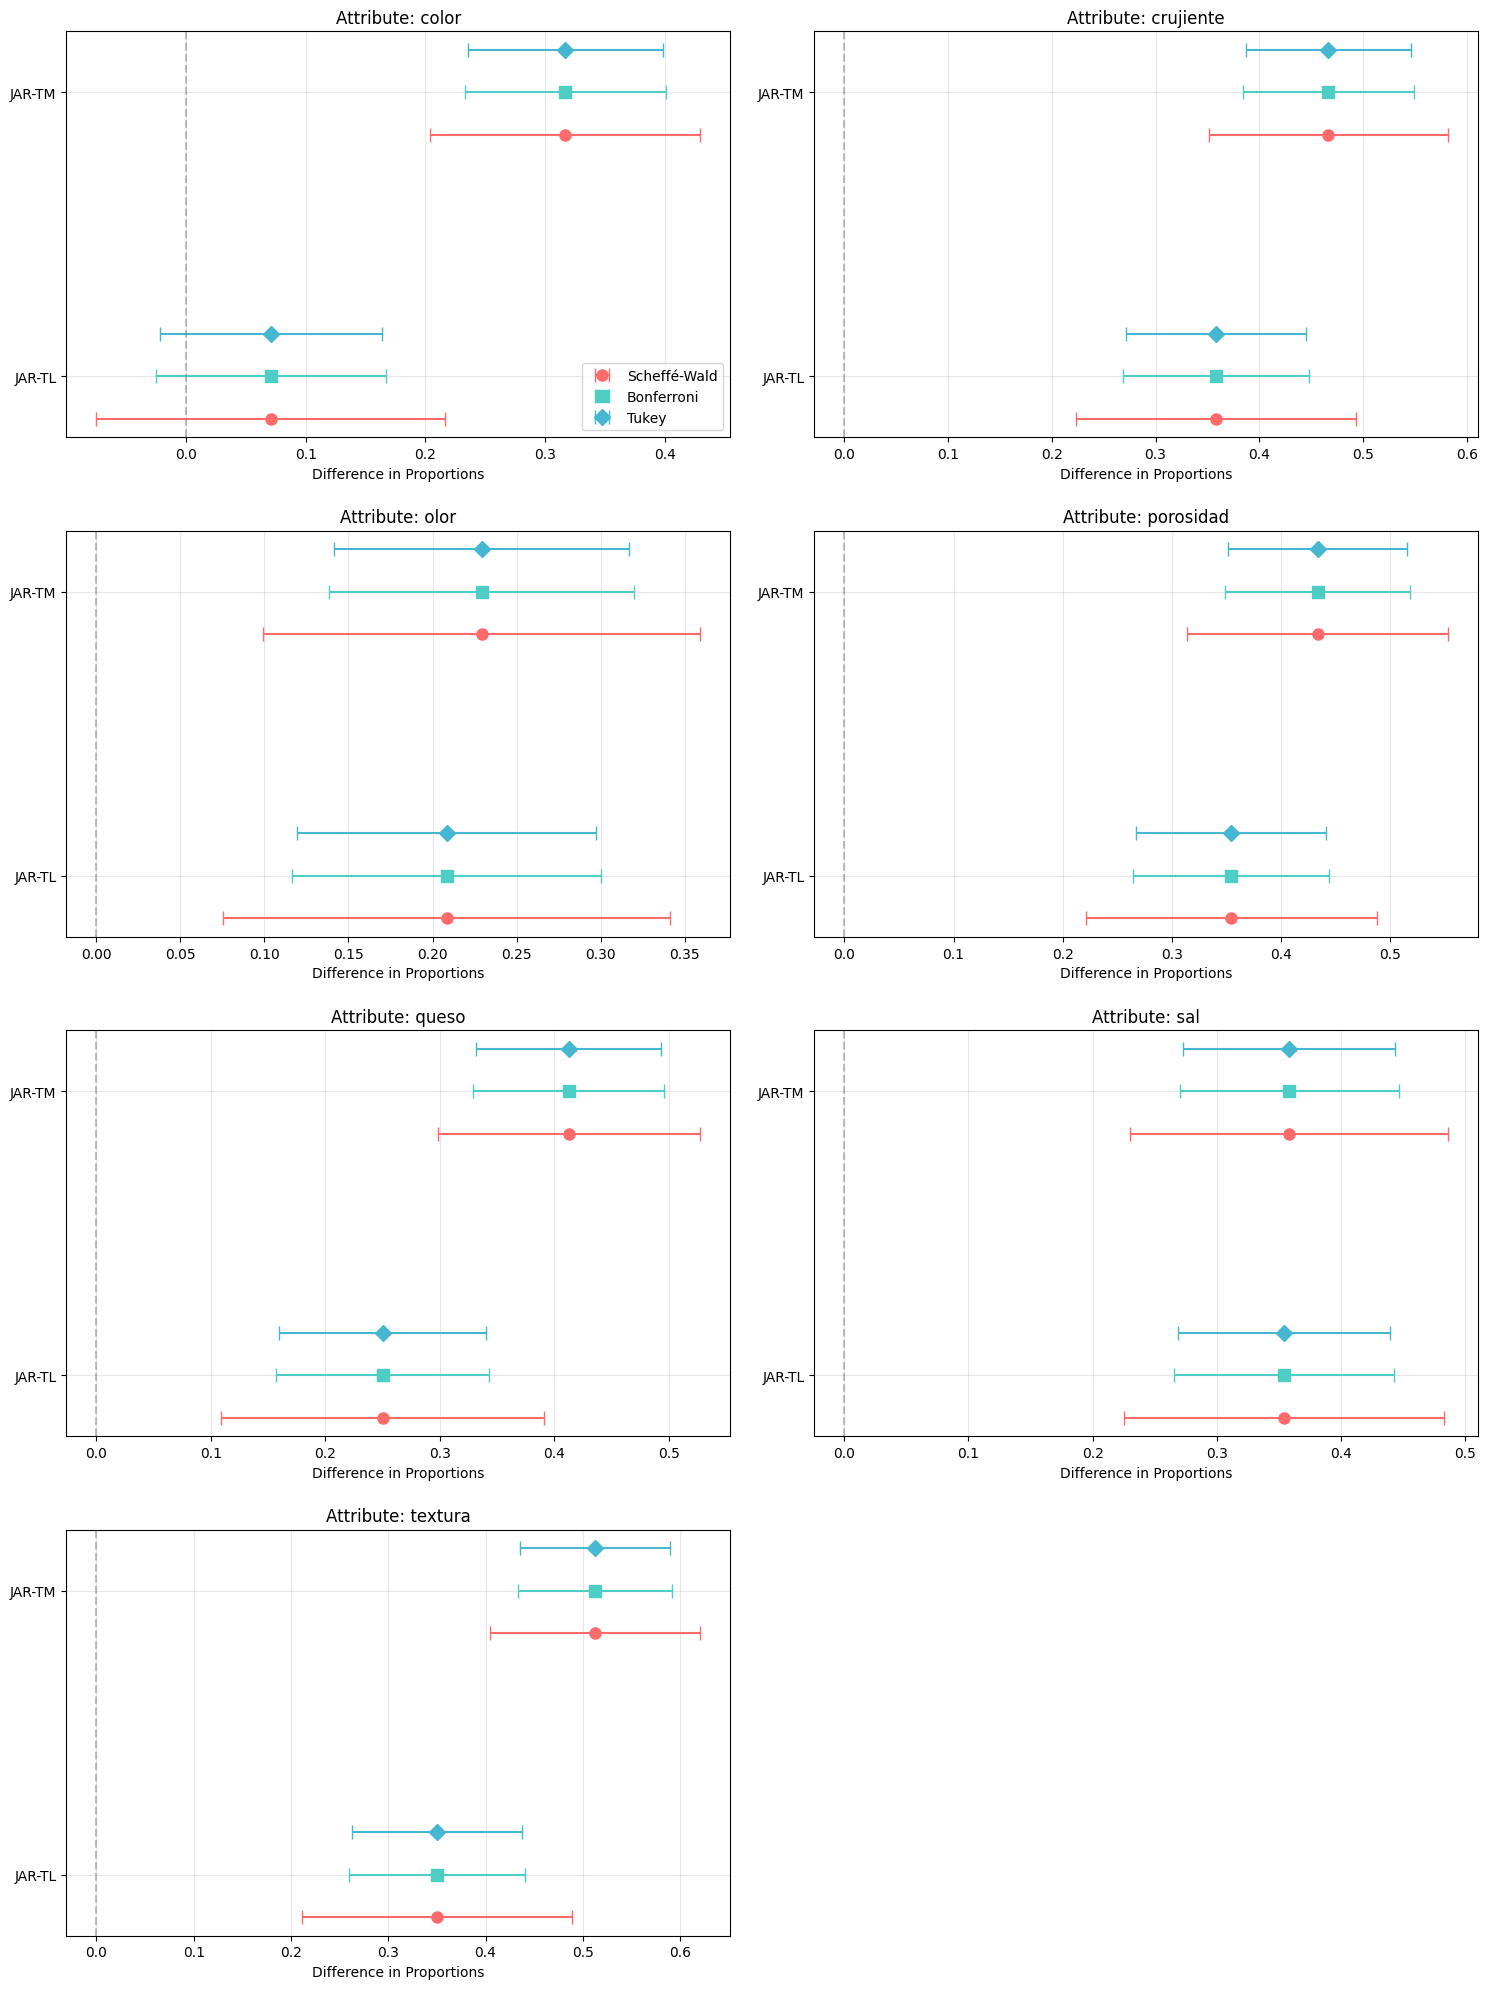

In [11]:

fig = plt.figure(figsize=(15, 10))
attributes = df_result['attribute'].unique()
n_attrs = len(attributes)
rows = int(np.ceil(n_attrs/2))
fig, axes = plt.subplots(rows, 2, figsize=(15, 5*rows))
axes = axes.flatten()

# Plot for each attribute
for idx, attr in enumerate(attributes):
    ax = axes[idx]
    attr_data = df_result[(df_result['attribute'] == attr ) & (df_result['p_i-p_j'] != 'TL-TM')]
    
    y_positions = []
    y_labels = []
    current_pos = 0
    
    for comp in attr_data['p_i-p_j'].unique():
        comp_data = attr_data[attr_data['p_i-p_j'] == comp]
        
        # Add small offset for each test method
        for i, (_, row) in enumerate(comp_data.iterrows()):
            offset = i * 0.3 - (len(comp_data) - 1) * 0.15  # Center the methods
            y_pos = current_pos + offset
            
            ax.errorbar(
                x=row['diff'],
                y=y_pos,
                xerr=[[row['diff'] - row['conf_low']], [row['conf_hi'] - row['diff']]],
                fmt=markers[row['test']],
                color=colors[row['test']],
                capsize=5,
                label=row['test'] if current_pos == 0 else "",
                markersize=8
            )
            
        y_positions.append(current_pos)
        y_labels.append(comp)
        current_pos += 2.0  # Space between comparisons
    
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Difference in Proportions')
    ax.set_title(f'Attribute: {attr}')
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend()

# Remove empty subplots
for idx in range(len(attributes), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(h_pad=2.0, w_pad=2.0)
plt.show()

# Penalty

In [36]:
penalties = df_result.loc[
    (df_result['p_value'] < alpha) & (df_result['p_i-p_j'] != "TL-TM"), 
    ['test','attribute','p_i-p_j']
].copy()

penalties['nivel'] = penalties['p_i-p_j'].str.split('-').str[1]

penalties = penalties.drop('p_i-p_j', axis = 1)
penalties.to_csv(os.path.join(MAIN_DIR,'df_penalties_all_test.csv'))

In [43]:
OVERALL_LIKING

,formula,nivel,overall_liking,proporcion,producto,atributo
0,182,JAR,8.180180,0.462500,Churritos Prueba,color
1,182,TL,6.702128,0.391667,Churritos Prueba,color
2,182,TM,8.000000,0.145833,Churritos Prueba,color
3,182,JAR,7.945205,0.608333,Churritos Prueba,crujiente
4,182,TL,6.533333,0.250000,Churritos Prueba,crujiente
5,182,TM,7.823529,0.141667,Churritos Prueba,crujiente
6,182,JAR,8.191304,0.479167,Churritos Prueba,olor
7,182,TL,6.830769,0.270833,Churritos Prueba,olor
8,182,TM,7.200000,0.250000,Churritos Prueba,olor
9,182,JAR,8.104895,0.595833,Churritos Prueba,porosidad


In [46]:
sw_penalties = (
    penalties[penalties['test'] == 'Scheffé-Wald']
    .copy()
    .drop('test', axis = 1)
)

sw_penalties = pd.merge(
    OVERALL_LIKING,
    sw_penalties, 
    how='left',
    right_on=['nivel','attribute'],
    left_on=['nivel','atributo']
)

sw_penalties

,formula,nivel,overall_liking,proporcion,producto,atributo,attribute
0,182,JAR,8.180180,0.462500,Churritos Prueba,color,NaN
1,182,TL,6.702128,0.391667,Churritos Prueba,color,NaN
2,182,TM,8.000000,0.145833,Churritos Prueba,color,color
3,182,JAR,7.945205,0.608333,Churritos Prueba,crujiente,NaN
4,182,TL,6.533333,0.250000,Churritos Prueba,crujiente,crujiente
5,182,TM,7.823529,0.141667,Churritos Prueba,crujiente,crujiente
6,182,JAR,8.191304,0.479167,Churritos Prueba,olor,NaN
7,182,TL,6.830769,0.270833,Churritos Prueba,olor,olor
8,182,TM,7.200000,0.250000,Churritos Prueba,olor,olor
9,182,JAR,8.104895,0.595833,Churritos Prueba,porosidad,NaN


In [48]:
# compute weights
ponderadores = (
    sw_penalties[sw_penalties['nivel'] != 'JAR']
    .copy()
    .groupby('atributo')['proporcion']
    .sum()
)

ponderadores

atributo
color        0.537500
crujiente    0.391667
olor         0.520833
porosidad    0.404167
queso        0.445833
sal          0.429167
textura      0.379167
Name: proporcion, dtype: float64

In [56]:
penalizadores_no_pond = (
    sw_penalties[['nivel','overall_liking','atributo']]
    .copy()
    .pivot(index='atributo',columns='nivel', values='overall_liking')
    .reset_index()
)

penalizadores_no_pond[['TL','TM']] = penalizadores_no_pond[['TL','TM']].apply(lambda x: penalizadores_no_pond['JAR']-x)

penalizadores_no_pond = (
    penalizadores_no_pond
    .drop('JAR', axis = 1)
)


penalizadores_no_pond

nivel,atributo,TL,TM
0,color,1.478053,0.180180
1,crujiente,1.411872,0.121676
2,olor,1.360535,0.991304
3,porosidad,1.673861,0.771562
4,queso,1.596251,0.687307
5,sal,1.287900,1.408187
6,textura,1.514404,0.199019


In [ ]:
penalty_result = (
    penalizadores_no_pond
    .copy()
    .melt(id_vars='atributo', value_name='penalizador_no_pond', var_name='nivel')
)

penalty_result['ponderador'] = penalty_result['atributo'].map(ponderadores)

penalty_result['penalty'] = penalty_result['penalizador_no_pond']*penalty_result['ponderador']
penalty_result = penalty_result.sort_values(by = 'penalty', ascending=False)

penalty_result

,atributo,nivel,penalizador_no_pond,ponderador,penalty
0,color,TL,1.478053,0.537500,0.794453
4,queso,TL,1.596251,0.445833,0.711662
2,olor,TL,1.360535,0.520833,0.708612
3,porosidad,TL,1.673861,0.404167,0.676519
12,sal,TM,1.408187,0.429167,0.604347
6,textura,TL,1.514404,0.379167,0.574211
1,crujiente,TL,1.411872,0.391667,0.552983
5,sal,TL,1.287900,0.429167,0.552724
9,olor,TM,0.991304,0.520833,0.516304
10,porosidad,TM,0.771562,0.404167,0.311840


In [64]:
penalty_result.shape[0]

14

In [12]:
import subprocess

subprocess.run('jupyter nbconvert --to markdown implementation.ipynb', 
                   shell=True, 
                   stdout=subprocess.DEVNULL, 
                   stderr=subprocess.DEVNULL, 
                   check=True)

subprocess.run('pandoc --listings -f markdown -t latex implementation.md -o implementation.tex', 
                   shell=True, 
                   stdout=subprocess.DEVNULL, 
                   stderr=subprocess.DEVNULL, 
                   check=True)


CompletedProcess(args='pandoc --listings -f markdown -t latex implementation.md -o implementation.tex', returncode=0)